## Importacion de librerias relevantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index_modified.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
'''df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')'''

"df_comp=df_comp.asfreq('b')\ndf_comp=df_comp.fillna(method='ffill')"

Adicion de la capitalizacion de mercado en el dataframe

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
## Eliminacion de columnas sobre dataframe original
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
## Separacion de la data para evaluar la eficacia de la modelo para entrenar y predecir los datos
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

El LLR (Likelihood Ratio Test o Prueba de la Razón de Verosimilitud, en español) es una prueba estadística utilizada para comparar la bondad de ajuste de dos modelos estadísticos, generalmente uno más simple (modelo restringido) y otro más complejo (modelo no restringido). El objetivo del LLR test es determinar si el modelo más complejo es significativamente mejor que el modelo más simple en términos de cómo se ajusta a los datos.
$$LLR=2×(ln(Verosimilitud \ del \ modelo \ no \ restringido )−ln(\ Verosimilitud \ del \ modelo \ restringido))$$
Se puede utilizar para comparar un modelo de regresión simple con un modelo de regresión más complejo que incluye más variables explicativas.En el análisis de series temporales, se utiliza para determinar si un modelo ARIMA con ciertos términos autorregresivos o de media móvil es significativamente mejor que un modelo más simple.El LLR test se utiliza en pruebas de hipótesis estadísticas para evaluar si la inclusión de parámetros adicionales en un modelo es justificada por una mejora significativa en la capacidad del modelo para ajustarse a los datos.

Funcion para la prueba de maxima verisimiliud para comprobar el ajuste entre los modelos 

In [5]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [6]:
## Importacion de libreria warning para la sentencia de advertencias
import warnings
warnings.filterwarnings("ignore")

## Creando Retornos

El uso de los retornos de las acciones es una práctica común en el análisis financiero y en la modelización en finanzas. Los retornos de las acciones se calculan para evaluar el rendimiento de una inversión en acciones a lo largo del tiempo y son esenciales para una variedad de aplicaciones, como la valoración de activos, la toma de decisiones de inversión y la gestión de riesgos. 
$$\frac{P_{t}-P_{t-1}}{P_{t-1}}$$

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ACF for Returns 

La ACF es una herramienta importante para examinar la correlación entre los valores de una serie temporal y sus retrasos pasados a lo largo del tiempo.Ya que puedes visualizar cómo la serie temporal se correlaciona consigo misma en diferentes rezagos (lags). 

#### Grafico de autocorrelacion completa para los retornos

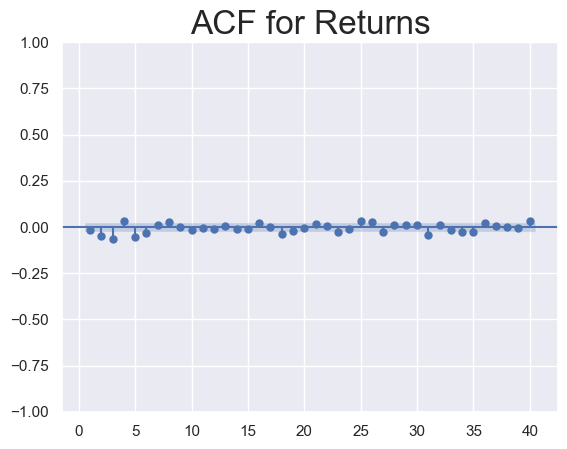

In [8]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

## Modelos MA

El proceso de medias móviles o (MA) por sus siglas en inglés (Moving Averages) es un modelo 
que supone que la variable puede ser explicada por un cierto número de rezagos (q) de los errores, 
es decir: $$
$$y_{t}=\phi_{1}u_{t-1}+\phi_{2}u_{t-2}+.....+\phi_{p}u_{t-p}+\mu$$
Donde los errores (u) son i.i.d. con media cero y varianza σ 2. A partir de esta sección se cambia 
el uso del subíndice i por t para referirse al tiempo. Se puede reescribir esta ecuación de la siguiente 
manera:
$$y_{t}=\mu + \sum_{j-1}^{q}\phi_{j}u_{t-j} + u_{t}$$

+ <b> Yt </b> = Valor de la serie temporal en el tiempo t 
+ <b> $\mu$ </b> : Media  
+ <b> $ \phi_{1},\phi_{2}...,\phi_{p}$ </b> = Coeficientes de autorregresion que multiplican los valores en los **p** periodos anteriores

El orden del MA, denotado como "q", se refiere a la cantidad de observaciones pasadas que se utilizan en el modelo para predecir el valor futuro. Por ejemplo, en un modelo MA(1), se utiliza solo una observación pasada, mientras que en un modelo MA(2), se utilizan dos observaciones pasadas.Los coeficientes del MA, denotados como "θ", son los pesos o coeficientes($ \phi_{1},\phi_{2}...,\phi_{p}$) aplicados a las observaciones pasadas en el modelo para calcular la predicción. Estos coeficientes se estiman a partir de los datos.

$$

## MA(1) for Returns

In [9]:
from statsmodels.tsa.arima.model import ARIMA

In [10]:
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0,0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -9512.742
Date:                Sat, 14 Oct 2023   AIC                          19031.485
Time:                        19:02:28   BIC                          19051.682
Sample:                             0   HQIC                         19038.487
                               - 6200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.333      0.183      -0.009       0.047
ma.L1         -0.0190      0.008     -2.515      0.012      -0.034      -0.004
sigma2         1.2595      0.011    112.045      0.000       1.237       1.282
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10124.53
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag MA Models for Returns

In [11]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -9505.136
Date:                Sat, 14 Oct 2023   AIC                          19018.272
Time:                        19:02:28   BIC                          19045.202
Sample:                             0   HQIC                         19027.609
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.395      0.163      -0.008       0.045
ma.L1         -0.0248      0.008     -3.230      0.001      -0.040      -0.010
ma.L2         -0.0486      0.007     -6.947      0.0

In [12]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -9489.139
Date:                Sat, 14 Oct 2023   AIC                          18988.279
Time:                        19:02:30   BIC                          19021.940
Sample:                             0   HQIC                         18999.949
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.013      1.476      0.140      -0.006       0.044
ma.L1         -0.0172      0.008     -2.228      0.026      -0.032      -0.002
ma.L2         -0.0539      0.007     -7.634      0.0

In [13]:
model_ret_ma_4 = ARIMA(df.returns[1:], order=[0,0,4])
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -9486.277
Date:                Sat, 14 Oct 2023   AIC                          18984.555
Time:                        19:02:33   BIC                          19024.949
Sample:                             0   HQIC                         18998.559
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1         -0.0165      0.008     -2.076      0.038      -0.032      -0.001
ma.L2         -0.0539      0.007     -7.535      0.0

In [14]:
model_ret_ma_5 = ARIMA(df.returns[1:], order=[0,0,5])
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -9478.252
Date:                Sat, 14 Oct 2023   AIC                          18970.504
Time:                        19:02:36   BIC                          19017.630
Sample:                             0   HQIC                         18986.842
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.013      1.488      0.137      -0.006       0.044
ma.L1         -0.0212      0.008     -2.607      0.009      -0.037      -0.005
ma.L2         -0.0491      0.007     -6.829      0.0

In [15]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=[0,0,6])
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -9475.219
Date:                Sat, 14 Oct 2023   AIC                          18966.437
Time:                        19:02:40   BIC                          19020.296
Sample:                             0   HQIC                         18985.110
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.012      1.523      0.128      -0.005       0.043
ma.L1         -0.0190      0.008     -2.337      0.019      -0.035      -0.003
ma.L2         -0.0484      0.007     -6.701      0.0

In [16]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=[0,0,7])
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -9474.973
Date:                Sat, 14 Oct 2023   AIC                          18967.946
Time:                        19:02:44   BIC                          19028.537
Sample:                             0   HQIC                         18988.952
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.013      1.504      0.133      -0.006       0.044
ma.L1         -0.0198      0.008     -2.412      0.016      -0.036      -0.004
ma.L2         -0.0488      0.007     -6.742      0.0

In [17]:
model_ret_ma_8 = ARIMA(df.returns[1:], order=[0,0,8])
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6200
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -9472.971
Date:                Sat, 14 Oct 2023   AIC                          18965.943
Time:                        19:02:50   BIC                          19033.266
Sample:                             0   HQIC                         18989.283
                               - 6200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.013      1.461      0.144      -0.006       0.044
ma.L1         -0.0194      0.008     -2.343      0.019      -0.036      -0.003
ma.L2         -0.0489      0.007     -6.727      0.0

In [18]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF = 2)

0.106

## Residuals for Returns

In [19]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [20]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is -0.0
The variance of the residuals is 1.244


In [21]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.115

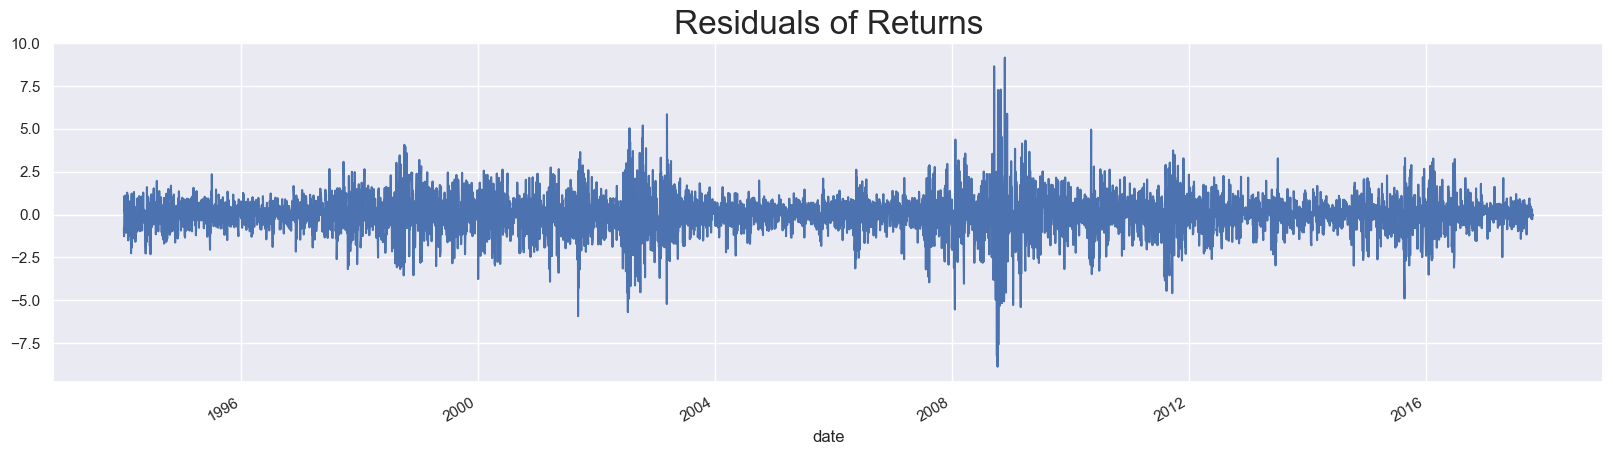

In [22]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [23]:
sts.adfuller(df.res_ret_ma_8[2:])

(-78.72503627107407,
 0.0,
 0,
 6198,
 {'1%': -3.4314055034463933,
  '5%': -2.8620064382326373,
  '10%': -2.5670182822217993},
 18854.685403374307)

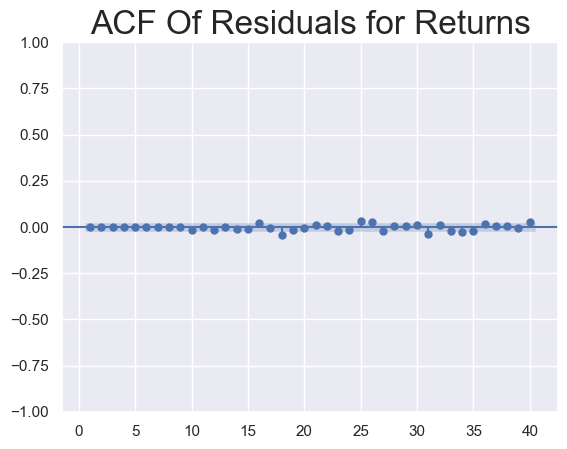

In [24]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Normalized Returns

In [25]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

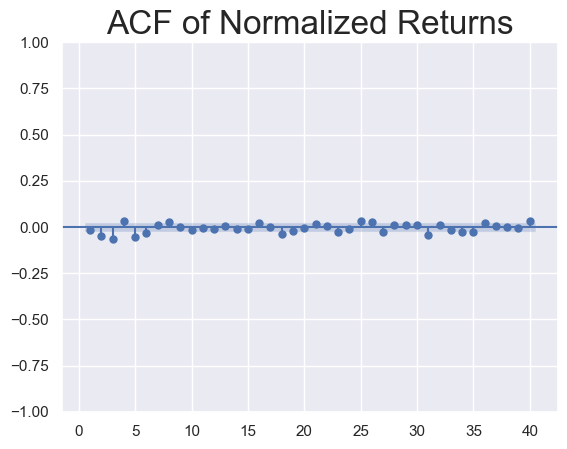

In [26]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

In [28]:
model_norm_ret_ma_8 = ARIMA(df.norm_ret[1:], order=(0,0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 6200
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -49516.083
Date:                Sat, 14 Oct 2023   AIC                          99052.167
Time:                        19:03:22   BIC                          99119.490
Sample:                             0   HQIC                         99075.507
                               - 6200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.0637      8.291     -1.455      0.146     -28.314       4.187
ma.L1         -0.0194      0.008     -2.336      0.019      -0.036      -0.003
ma.L2         -0.0489      0.007     -6.708      0.000      -0.063      -0.035
ma.L3         -0.0689      0.007     -9.430      0.000      -0.083      -0.055
ma.L4          0.0318      0.008      4.128      0.000       0.017       0.047
ma.L5         -0.0535      0.007     -7.289      0.000      -0.068      -0.039
ma.L6         -0.0328      0.008     -4.065      0.000      -0.049      -0.017
ma.L7          0.0091      0.008      1.142      0.253      -0.007       0.025
ma.L8          0.0250      0.008      2.988      0.003       0.009       0.041
sigma2      5.077e+05   4938.069    102.822      0.000    4.98e+05    5.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8526.39
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
df['res_norm_ret_ma_8'] = results_ret_ma_8.resid[1:]

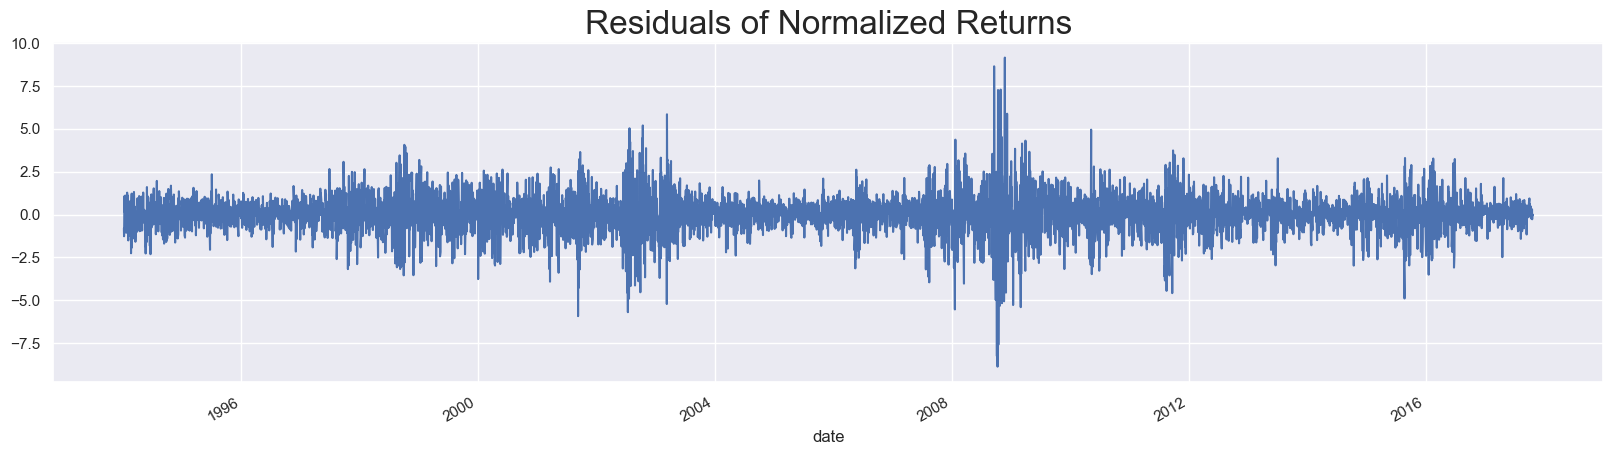

In [30]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

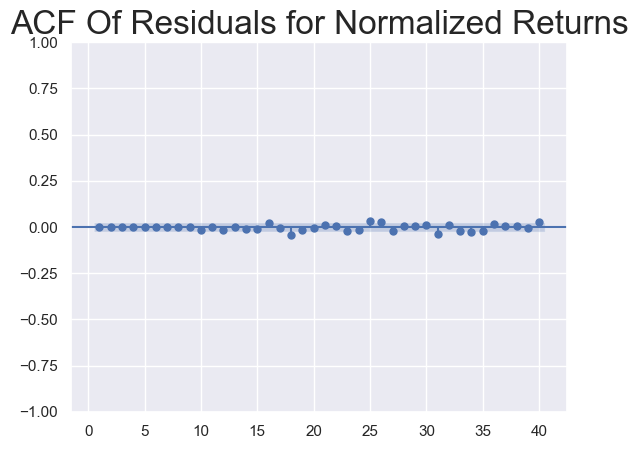

In [31]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

## MA Models For Prices

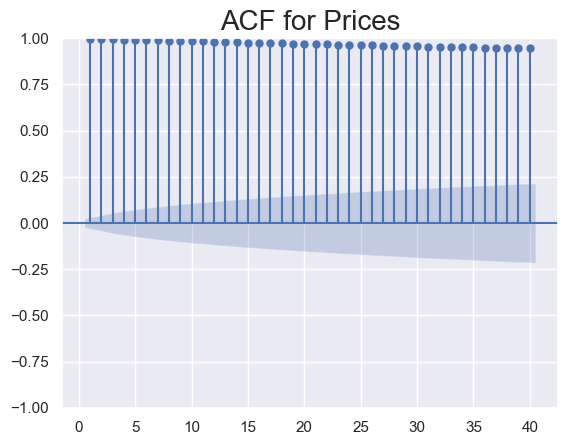

In [32]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

In [34]:
model_ma_1 = ARIMA(df.market_value, order=(0,0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6201
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -48331.460
Date:                Sat, 14 Oct 2023   AIC                          96668.921
Time:                        19:03:43   BIC                          96689.118
Sample:                             0   HQIC                         96675.923
                               - 6201                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5399.5105     15.698    343.953      0.000    5368.742    5430.279
ma.L1          0.9601      0.004    271.092      0.000       0.953       0.967
sigma2      3.446e+05   8419.624     40.930      0.000    3.28e+05    3.61e+05
===================================================================================
Ljung-Box (L1) (Q):                5354.40   Jarque-Bera (JB):               317.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""